# Decision Tree Classifier

Berikut ini merupakan implementasi machine learning pada dataset playtennis menggunakan library scikit-learn.

---
## Setup Library dan Dataset

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

full_data_X = pd.read_csv('PlayTennis.csv')
full_data_X.dropna(axis=0, subset=['Play Tennis'], inplace=True)
full_data_Y = full_data_X['Play Tennis']
full_data_X.drop(['Play Tennis'], axis=1, inplace=True)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(full_data_X, full_data_Y, 
                                                                train_size=0.8, test_size=0.2)

# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]

full_data_X.head()

,Outlook,Temperature,Humidity,Wind
0,Sunny,Hot,High,Weak
1,Sunny,Hot,High,Strong
2,Overcast,Hot,High,Weak
3,Rain,Mild,High,Weak
4,Rain,Cool,Normal,Weak


---
## Preprocessing and Pipelining

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing for numerical data
numerical_transformer = SimpleImputer()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

---
## Create model

In [15]:
from sklearn import tree
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Define model
modelDtl = tree.DecisionTreeClassifier(random_state=0)
modelID3 = Id3Estimator()
kmeans = KMeans(n_clusters=2, random_state=0)
modelLogistic = LogisticRegression(random_state=0, max_iter=100)
modelNeural = MLPClassifier(random_state=0, max_iter=300)
modelSVM = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=0))

# Bundle preprocessing and modeling code in a pipeline
dtl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', modelDtl)
                     ])

modID3 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', modelID3)
                     ])

modelKmeans = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', kmeans)
                     ])

modlogistic = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', modelLogistic)
                     ])

modNeural = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', modelNeural)
                     ])

modSVM = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', modelSVM)
                     ])

---
## Fitting and predict

### Decision Tree Learning

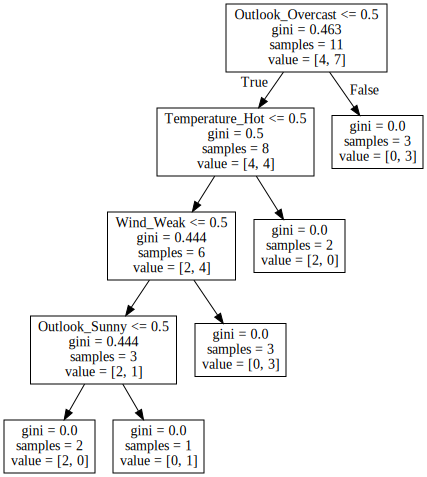

In [16]:
import graphviz
# Preprocessing of training data, fit model 
dtl.fit(X_train_full, y_train)
#r = tree.export_text(model, feature_names = [d for d in data.feature_names])
dot_data = tree.export_graphviz(modelDtl, 
                  feature_names=dtl.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(X_train_full.columns))
graph = graphviz.Source(dot_data)

# Preprocessing of validation data, get predictions
predsDtl = dtl.predict(X_valid_full)
graph

### ID3 Estimator

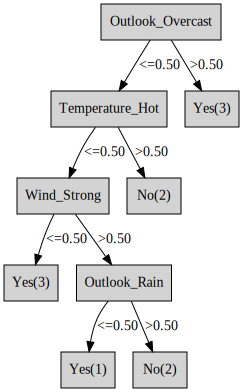

In [17]:
from id3 import export_graphviz

# Preprocessing of training data, fit model 
modID3.fit(X_train_full, y_train)

#r = tree.export_text(model, feature_names = [d for d in data.feature_names])
dot_treeID3 = export_graphviz(modelID3.tree_, 'graph.dot', 
                  feature_names=dtl.named_steps['preprocessor'].transformers_[1][1]\
   .named_steps['onehot'].get_feature_names(X_train_full.columns), 
                  )
with open("graph.dot") as f:
    dot_graphID3 = f.read()
graphID3 = graphviz.Source(dot_graphID3)

# Preprocessing of validation data, get predictions
predsID3 = modID3.predict(X_valid_full)

graphID3

### K-Means

In [18]:
modelKmeans.fit(X_train_full, y_train)

predsKmeans = ['Yes' if item==1 else 'No' for item in modelKmeans.predict(X_valid_full)]
predsKmeans

['No', 'Yes', 'No']

### Logistic Regression

In [19]:
modlogistic.fit(X_train_full, y_train)

predsLogistic = modlogistic.predict(X_valid_full)
predsLogistic

array(['Yes', 'Yes', 'Yes'], dtype=object)

### Neural Network

In [20]:
modNeural.fit(X_train_full, y_train)
predsNeural = modNeural.predict(X_valid_full)
predsNeural

C:\Python 36-64\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


array(['Yes', 'Yes', 'Yes'], dtype='<U3')

### SVM

In [21]:
modSVM.fit(X_train_full, y_train)
predsSVM = modSVM.predict(X_valid_full)
predsSVM

array(['Yes', 'Yes', 'Yes'], dtype=object)

---
## Accuracy and F1 Score

In [22]:
from sklearn.metrics import accuracy_score, f1_score

accuracy = [accuracy_score(y_valid, predsDtl),accuracy_score(y_valid, predsID3),accuracy_score(y_valid, predsKmeans),accuracy_score(y_valid, predsLogistic),accuracy_score(y_valid, predsNeural),accuracy_score(y_valid, predsSVM)]
f1 = [f1_score(y_valid, predsDtl, pos_label='Yes'), f1_score(y_valid, predsID3, pos_label='Yes'), f1_score(y_valid, predsKmeans, pos_label='Yes'), f1_score(y_valid, predsLogistic, pos_label='Yes'), f1_score(y_valid, predsNeural, pos_label='Yes'), f1_score(y_valid, predsSVM, pos_label='Yes')]
score_data = {'accuracy': accuracy, 'f1': f1}
score = pd.DataFrame(data = score_data, index=['Decision Tree Learning', 'ID3 Estimator', 'K-Means', 'Logistic Regression', 'Neural Network', 'SVM'])
score

,accuracy,f1
Decision Tree Learning,0.666667,0.8
ID3 Estimator,0.666667,0.8
K-Means,0.000000,0.0
Logistic Regression,0.666667,0.8
Neural Network,0.666667,0.8
SVM,0.666667,0.8
